In [ ]:
# =========================================
# 0. Imports
# =========================================
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from huggingface_hub import login, list_repo_files, hf_hub_download

# =========================================
# 1. Konfiguration
# =========================================
REPO_ID = "mttfst/Paulette_Cloud_Tracks"
token = "hf_XXX"

PAD_VALUE = -99.0
TIMESTEP_SECONDS = 30.0
CUTOFF_STEPS = 5

BATCH_SIZE = 8
EPOCHS = 40

# =========================================
# 2. Login HuggingFace
# =========================================
login(token)

# =========================================
# 3. Feature-Definition
# =========================================
SCALAR_BASE_FEATURES = [
    "cape_ml_L00",
    "cin_ml_L00",
    "lwp_L00",
    "iwp_L00",
    "tqc_L00",
    "tqi_L00",
    "rain_gsp_rate_L00",
    "area_m2",
    "age_s",
]

def get_scalar_feature_columns(df):
    return [c for c in SCALAR_BASE_FEATURES if c in df.columns]

# =========================================
# 4. Track-Preprocessing
# =========================================
def add_stats_features_placeholder(df, timestep_seconds=30.0):
    df = df.copy()

    df["track_length_s"] = (len(df) - 1) * timestep_seconds
    df["age_frac"] = df["age_s"] / df["track_length_s"]

    df["d_area_dt"] = df["area_m2"].diff().fillna(0.0) / timestep_seconds
    df["area_mean_5"] = df["area_m2"].rolling(5, min_periods=1).mean()

    return df


def preprocess_track(df, timestep_seconds=30.0):
    df = df.copy()

    if "frame" in df.columns:
        df = df.sort_values("frame").reset_index(drop=True)

    T = len(df)

    df["frame"] = np.arange(T)
    df["age_s"] = df["frame"] * timestep_seconds
    df["remaining_lifetime_s"] = (T - 1 - df["frame"]) * timestep_seconds

    drop_cols = ["time", "latitude", "longitude", "cell", "feature", "feature_orig"]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    df = add_stats_features_placeholder(df, timestep_seconds)
    return df


def load_track(csv_path):
    local_path = hf_hub_download(
        repo_id=REPO_ID,
        repo_type="dataset",
        filename=csv_path,
    )
    df = pd.read_csv(local_path)
    return preprocess_track(df)



In [3]:
# =========================================
# 5. Dataset-Split
# =========================================
files = list_repo_files(REPO_ID, repo_type="dataset")
csv_files = [f for f in files if f.startswith("exp_1.1/") and f.endswith(".csv")]

tracks_120 = pd.read_csv("/content/hurricane_cloud_prediction/5_Data_Sample/track_len.csv")

tracks_120 = tracks_120[tracks_120.track_len >= 120]
print("Total CSV tracks with at least 120 timesteps:", len(tracks_120))

tracks_120 = tracks_120.filename.to_list()

csv_files = [
    f for f in csv_files
    if f.split("/")[1] in tracks_120
]

random.seed(42)
random.shuffle(csv_files)

n = len(csv_files)
train_files = csv_files[: int(0.7 * n)]
val_files   = csv_files[int(0.7 * n): int(0.85 * n)]
test_files  = csv_files[int(0.85 * n):]

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")



Total CSV tracks with at least 120 timesteps: 1115
Train: 780, Val: 167, Test: 168


In [4]:
def get_max_track_length(file_list):
    max_len = 0
    for path in file_list:
        df = load_track(path)
        max_len = max(max_len, len(df))
    return max_len

MAX_LEN = get_max_track_length(train_files + val_files + test_files)
print("Global max sequence length:", MAX_LEN)

# =========================================
# 6. Sequenz-Dataset bauen (many-to-many)
# =========================================
def build_sequence_dataset(file_list, max_len):
    X_seqs, y_seqs = [], []

    for path in file_list:
        df = load_track(path)

        feature_cols = get_scalar_feature_columns(df)

        X = df[feature_cols].to_numpy(np.float32)
        y = df["remaining_lifetime_s"].to_numpy(np.float32)[:, None]

        X_seqs.append(X)
        y_seqs.append(y)

    X_pad = pad_sequences(
        X_seqs, padding="post", maxlen=max_len, value=PAD_VALUE, dtype="float32"
    )
    y_pad = pad_sequences(
        y_seqs, padding="post", maxlen=max_len, value=PAD_VALUE, dtype="float32"
    )

    return X_pad, y_pad, feature_cols


X_train, y_train, feature_cols = build_sequence_dataset(train_files, MAX_LEN)
X_val,   y_val,   _            = build_sequence_dataset(val_files, MAX_LEN)
X_test,  y_test,  _            = build_sequence_dataset(test_files, MAX_LEN)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")



Global max sequence length: 665
X_train shape: (780, 665, 9)
y_train shape: (780, 665, 1)


In [13]:
# =========================================
# LÖSUNG: NaN in der Normalisierung beheben
# =========================================

import numpy as np
from sklearn.preprocessing import StandardScaler

def robust_normalize_sequences(X_train, X_val, X_test, pad_value=PAD_VALUE):
    """
    Robuste Feature-Normalisierung die NaN vermeidet
    
    Problem: StandardScaler erzeugt NaN wenn std=0 (konstante Features)
    Lösung: Prüfe und handle konstante Features separat
    """
    n, T, F = X_train.shape
    print(f"\n📊 Normalisiere {F} Features...")
    
    # Reshape für Scaler
    Xf_train = X_train.reshape(-1, F)
    mask = Xf_train[:, 0] != pad_value
    
    # Nur gültige (nicht-gepadete) Werte
    valid_data = Xf_train[mask]
    print(f"   Gültige Samples: {len(valid_data)}")
    
    # ============================================
    # WICHTIG: Finde konstante Features VOR dem Scaling
    # ============================================
    constant_features = []
    feature_stats = []
    
    for i in range(F):
        feature_values = valid_data[:, i]
        
        # Entferne NaN/Inf die möglicherweise schon da sind
        clean_values = feature_values[~np.isnan(feature_values) & ~np.isinf(feature_values)]
        
        if len(clean_values) == 0:
            print(f"   ⚠️  Feature {i}: Keine gültigen Werte - wird entfernt")
            constant_features.append(i)
            feature_stats.append({'mean': 0, 'std': 0, 'is_constant': True})
            continue
        
        mean_val = np.mean(clean_values)
        std_val = np.std(clean_values)
        
        # Feature ist konstant wenn std sehr klein
        if std_val < 1e-8:
            print(f"   ⚠️  Feature {i}: Konstant (std={std_val:.2e}) - wird mit 0 gefüllt")
            constant_features.append(i)
            feature_stats.append({'mean': mean_val, 'std': 0, 'is_constant': True})
        else:
            feature_stats.append({'mean': mean_val, 'std': std_val, 'is_constant': False})
    
    print(f"   Gefunden: {len(constant_features)} konstante Features")
    
    # ============================================
    # Custom Scaler der konstante Features handlet
    # ============================================
    class RobustScaler:
        def __init__(self, feature_stats):
            self.feature_stats = feature_stats
            self.n_features = len(feature_stats)
        
        def transform(self, X):
            """Transformiere Features, handle konstante separat"""
            X_scaled = np.zeros_like(X)
            
            for i in range(self.n_features):
                if self.feature_stats[i]['is_constant']:
                    # Konstante Features → setze auf 0
                    X_scaled[:, i] = 0.0
                else:
                    # Normale Standardisierung
                    mean = self.feature_stats[i]['mean']
                    std = self.feature_stats[i]['std']
                    X_scaled[:, i] = (X[:, i] - mean) / std
            
            return X_scaled
    
    scaler = RobustScaler(feature_stats)
    
    # ============================================
    # Transformiere Daten
    # ============================================
    def transform_dataset(X):
        Xf = X.reshape(-1, F)
        mask = Xf[:, 0] != pad_value
        
        if np.sum(mask) > 0:
            # Transformiere nur gültige Werte
            Xf[mask] = scaler.transform(Xf[mask])
            
            # SICHERHEITSCHECK: Ersetze verbleibende NaN mit 0
            nan_mask = mask & np.isnan(Xf).any(axis=1)
            if np.sum(nan_mask) > 0:
                print(f"   ⚠️  {np.sum(nan_mask)} NaN gefunden - werden mit 0 ersetzt")
                Xf[nan_mask] = 0.0
        
        return Xf.reshape(X.shape)
    
    X_train_norm = transform_dataset(X_train)
    X_val_norm = transform_dataset(X_val)
    X_test_norm = transform_dataset(X_test)
    
    # ============================================
    # Finale Validierung
    # ============================================
    print(f"\n✅ Normalisierung abgeschlossen:")
    print(f"   X_train - NaN: {np.isnan(X_train_norm).sum()}, Inf: {np.isinf(X_train_norm).sum()}")
    print(f"   X_val   - NaN: {np.isnan(X_val_norm).sum()}, Inf: {np.isinf(X_val_norm).sum()}")
    print(f"   X_test  - NaN: {np.isnan(X_test_norm).sum()}, Inf: {np.isinf(X_test_norm).sum()}")
    
    return X_train_norm, X_val_norm, X_test_norm, scaler

In [14]:
X_train, X_val, X_test, scaler = robust_normalize_sequences(X_train, X_val, X_test)


📊 Normalisiere 9 Features...
   Gültige Samples: 168339
   Gefunden: 0 konstante Features
   ⚠️  151495 NaN gefunden - werden mit 0 ersetzt
   ⚠️  32173 NaN gefunden - werden mit 0 ersetzt
   ⚠️  29289 NaN gefunden - werden mit 0 ersetzt

✅ Normalisierung abgeschlossen:
   X_train - NaN: 0, Inf: 0
   X_val   - NaN: 0, Inf: 0
   X_test  - NaN: 0, Inf: 0


In [5]:
# =========================================
# 7. Y-Target Normalisierung (WICHTIG!)
# =========================================
# Problem: remaining_lifetime_s kann sehr groß sein (Tausende)
# Lösung: Normalisiere auch die Targets
def normalize_targets(y_train, y_val, y_test, pad_value=PAD_VALUE):
    """Normalisiert die Target-Werte (remaining_lifetime_s)"""
    
    # Finde nicht-gepadete Werte
    mask_train = y_train != pad_value
    
    # Berechne Statistiken nur auf echten Werten
    valid_values = y_train[mask_train]
    y_mean = np.mean(valid_values)
    y_std = np.std(valid_values)
    
    print(f"Target Stats - Mean: {y_mean:.2f}s, Std: {y_std:.2f}s")
    
    # Normalisiere
    def normalize(y):
        y_norm = y.copy()
        mask = y != pad_value
        y_norm[mask] = (y[mask] - y_mean) / y_std
        return y_norm
    
    return normalize(y_train), normalize(y_val), normalize(y_test), y_mean, y_std

y_train_norm, y_val_norm, y_test_norm, y_mean, y_std = normalize_targets(
    y_train, y_val, y_test
)

# =========================================
# 8. X-Feature Normalisierung
# =========================================
def normalize_sequences(X_train, X_val, X_test):
    n, T, F = X_train.shape

    scaler = StandardScaler()
    Xf = X_train.reshape(-1, F)
    mask = Xf[:, 0] != PAD_VALUE
    scaler.fit(Xf[mask])

    def transform(X):
        Xf = X.reshape(-1, F)
        mask = Xf[:, 0] != PAD_VALUE
        Xf[mask] = scaler.transform(Xf[mask])
        return Xf.reshape(X.shape)

    return transform(X_train), transform(X_val), transform(X_test), scaler

X_train, X_val, X_test, scaler = normalize_sequences(X_train, X_val, X_test)

# =========================================
# 9. Cutoff anwenden
# =========================================
def apply_cutoff(y, cutoff_steps):
    y = y.copy()
    y[:, -cutoff_steps:, :] = PAD_VALUE
    return y

y_train_norm = apply_cutoff(y_train_norm, CUTOFF_STEPS)
y_val_norm   = apply_cutoff(y_val_norm,   CUTOFF_STEPS)
y_test_norm  = apply_cutoff(y_test_norm,  CUTOFF_STEPS)



Target Stats - Mean: 3708.93s, Std: 2754.87s


In [15]:
# =========================================
# 1. Überprüfe die Daten nach Normalisierung
# =========================================
print("\n1. DATEN-CHECKS:")
print("-" * 60)

# X Daten
print(f"X_train shape: {X_train.shape}")
print(f"X_train dtype: {X_train.dtype}")
print(f"X_train min: {np.min(X_train[X_train != PAD_VALUE]):.6f}")
print(f"X_train max: {np.max(X_train[X_train != PAD_VALUE]):.6f}")
print(f"X_train mean: {np.mean(X_train[X_train != PAD_VALUE]):.6f}")
print(f"X_train std: {np.std(X_train[X_train != PAD_VALUE]):.6f}")

print(f"\nNaN in X_train: {np.isnan(X_train).any()}")
print(f"Inf in X_train: {np.isinf(X_train).any()}")
if np.isnan(X_train).any():
    print(f"  → Anzahl NaN: {np.isnan(X_train).sum()}")
if np.isinf(X_train).any():
    print(f"  → Anzahl Inf: {np.isinf(X_train).sum()}")

# Y Daten
print(f"\ny_train_norm shape: {y_train_norm.shape}")
print(f"y_train_norm dtype: {y_train_norm.dtype}")
print(f"y_train_norm min: {np.min(y_train_norm[y_train_norm != PAD_VALUE]):.6f}")
print(f"y_train_norm max: {np.max(y_train_norm[y_train_norm != PAD_VALUE]):.6f}")
print(f"y_train_norm mean: {np.mean(y_train_norm[y_train_norm != PAD_VALUE]):.6f}")
print(f"y_train_norm std: {np.std(y_train_norm[y_train_norm != PAD_VALUE]):.6f}")

print(f"\nNaN in y_train_norm: {np.isnan(y_train_norm).any()}")
print(f"Inf in y_train_norm: {np.isinf(y_train_norm).any()}")
if np.isnan(y_train_norm).any():
    print(f"  → Anzahl NaN: {np.isnan(y_train_norm).sum()}")
if np.isinf(y_train_norm).any():
    print(f"  → Anzahl Inf: {np.isinf(y_train_norm).sum()}")



1. DATEN-CHECKS:
------------------------------------------------------------
X_train shape: (780, 665, 9)
X_train dtype: float32
X_train min: -7.330227
X_train max: 10.591553
X_train mean: 0.000014
X_train std: 0.316072

NaN in X_train: False
Inf in X_train: False

y_train_norm shape: (780, 665, 1)
y_train_norm dtype: float32
y_train_norm min: -1.346318
y_train_norm max: 5.122223
y_train_norm mean: -0.000000
y_train_norm std: 1.000000

NaN in y_train_norm: False
Inf in y_train_norm: False


In [16]:
# =========================================
# 10. Custom Loss Function (KRITISCH!)
# =========================================
def masked_mse_loss(pad_value=PAD_VALUE):
    """
    MSE Loss der nur nicht-gepadete Werte berücksichtigt.
    Dies ist ESSENTIELL um nan-Loss zu vermeiden!
    """
    def loss(y_true, y_pred):
        # Maske: wo sind echte Werte?
        mask = tf.not_equal(y_true, pad_value)
        mask = tf.cast(mask, tf.float32)
        
        # Berechne quadratischen Fehler
        squared_error = tf.square(y_true - y_pred)
        
        # Multipliziere mit Maske (setzt gepadete Werte auf 0)
        masked_error = squared_error * mask
        
        # Summiere und teile durch Anzahl echter Werte
        sum_error = tf.reduce_sum(masked_error)
        count = tf.reduce_sum(mask)
        
        # Verhindere Division durch 0
        count = tf.maximum(count, 1.0)
        
        return sum_error / count
    
    return loss

# Optional: Custom Metric für bessere Übersicht
def masked_mae_metric(pad_value=PAD_VALUE):
    """MAE Metrik die gepadete Werte ignoriert"""
    def metric(y_true, y_pred):
        mask = tf.not_equal(y_true, pad_value)
        mask = tf.cast(mask, tf.float32)
        
        abs_error = tf.abs(y_true - y_pred)
        masked_error = abs_error * mask
        
        sum_error = tf.reduce_sum(masked_error)
        count = tf.reduce_sum(mask)
        count = tf.maximum(count, 1.0)
        
        return sum_error / count
    
    return metric



In [17]:
# =========================================
# 11. Verbessertes RNN Modell
# =========================================
def build_improved_rnn(input_shape):
    """
    Verbessertes RNN mit:
    - Gradient Clipping (verhindert exploding gradients)
    - Dropout (Regularisierung)
    - Batch Normalization (stabileres Training)
    """
    inputs = layers.Input(shape=input_shape)

    # Masking Layer
    x = layers.Masking(mask_value=PAD_VALUE)(inputs)

    # Erste RNN Schicht mit Dropout
    x = layers.SimpleRNN(
        64, 
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2
    )(x)
    
    # Batch Normalization für stabileres Training
    x = layers.BatchNormalization()(x)

    # Zweite RNN Schicht
    x = layers.SimpleRNN(
        32, 
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2
    )(x)

    # Output Layer
    outputs = layers.TimeDistributed(layers.Dense(1))(x)

    model = models.Model(inputs, outputs)
    
    # Optimizer mit Gradient Clipping
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=0.75  # Verhindert zu große Gradienten
    )
    
    model.compile(
        optimizer=optimizer,
        loss=masked_mse_loss(PAD_VALUE),
        metrics=[masked_mae_metric(PAD_VALUE)]
    )
    return model


model = build_improved_rnn(X_train.shape[1:])
model.summary()

# =========================================
# 12. Training mit verbessertem Monitoring
# =========================================
# Callbacks für besseres Training
callbacks = [
    # Early Stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Learning Rate Reduction
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    # NaN Detection
    tf.keras.callbacks.TerminateOnNaN()
]

print("\n" + "="*60)
print("STARTE TRAINING")
print("="*60)

history = model.fit(
    X_train, y_train_norm,
    verbose=1,
    validation_data=(X_val, y_val_norm),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 665, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 665, 9)    │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_4 (Masking) │ (None, 665, 9)    │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_4 (Any)         │ (None, 665)       │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_8        │ (None, 665, 64)   │      4,736 │ masking_4[0][0],  │
│ (SimpleRNN)         │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 665, 64)   │        256 │ simple_rnn_8[0][… │
│ (BatchNormalizatio… │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_9        │ (None, 665, 32)   │      3,104 │ batch_normalizat… │
│ (SimpleRNN)         │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 665, 1)    │         33 │ simple_rnn_9[0][… │
│ (TimeDistributed)   │                   │            │ any_4[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 128 (512.00 B)


STARTE TRAINING
Epoch 1/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 111s 734ms/step - loss: 1.3620 - metric: 0.9070 - val_loss: 1.1626 - val_metric: 0.7632 - learning_rate: 0.0010
Epoch 2/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 619ms/step - loss: 0.9105 - metric: 0.7403 - val_loss: 1.1125 - val_metric: 0.7642 - learning_rate: 0.0010
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 625ms/step - loss: 0.9248 - metric: 0.7365 - val_loss: 1.1011 - val_metric: 0.7304 - learning_rate: 0.0010
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 625ms/step - loss: 0.7829 - metric: 0.6854 - val_loss: 1.0987 - val_metric: 0.7285 - learning_rate: 0.0010
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 639ms/step - loss: 0.7548 - metric: 0.6674 - val_loss: 1.1213 - val_metric: 0.7495 - learning_rate: 0.0010
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 629ms/step - loss: 0.7589 - metric: 0.6653 - val_loss: 1.0815 - val_metric: 0.7215 - learning_rate: 0.0010
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 640ms/step - loss: 0.8487 - metric: 0.7064 - v

In [18]:
# =========================================
# 13. Evaluation
# =========================================
print("\n" + "="*60)
print("EVALUATION")
print("="*60)

test_loss = model.evaluate(X_test, y_test_norm, verbose=1)
print(f"\nTest Loss (normalized): {test_loss}")

# Mache Vorhersagen
y_pred_norm = model.predict(X_test, verbose=0)

# De-normalisiere für echte Metriken
def denormalize_predictions(y_norm, y_mean, y_std, pad_value=PAD_VALUE):
    y = y_norm.copy()
    mask = y != pad_value
    y[mask] = y[mask] * y_std + y_mean
    return y

y_pred = denormalize_predictions(y_pred_norm, y_mean, y_std)
y_test_denorm = denormalize_predictions(y_test_norm, y_mean, y_std)

# Berechne echte Metriken (in Sekunden)
mask = y_test_denorm != PAD_VALUE
mae_seconds = np.mean(np.abs(y_test_denorm[mask] - y_pred[mask]))
rmse_seconds = np.sqrt(np.mean((y_test_denorm[mask] - y_pred[mask])**2))

print(f"\nReal-world Metriken:")
print(f"MAE:  {mae_seconds:.2f} Sekunden ({mae_seconds/60:.2f} Minuten)")
print(f"RMSE: {rmse_seconds:.2f} Sekunden ({rmse_seconds/60:.2f} Minuten)")



EVALUATION
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.9093 - metric: 0.6631

Test Loss (normalized): [0.8177318572998047, 0.626767098903656]

Real-world Metriken:
MAE:  1821.73 Sekunden (30.36 Minuten)
RMSE: 2539.74 Sekunden (42.33 Minuten)


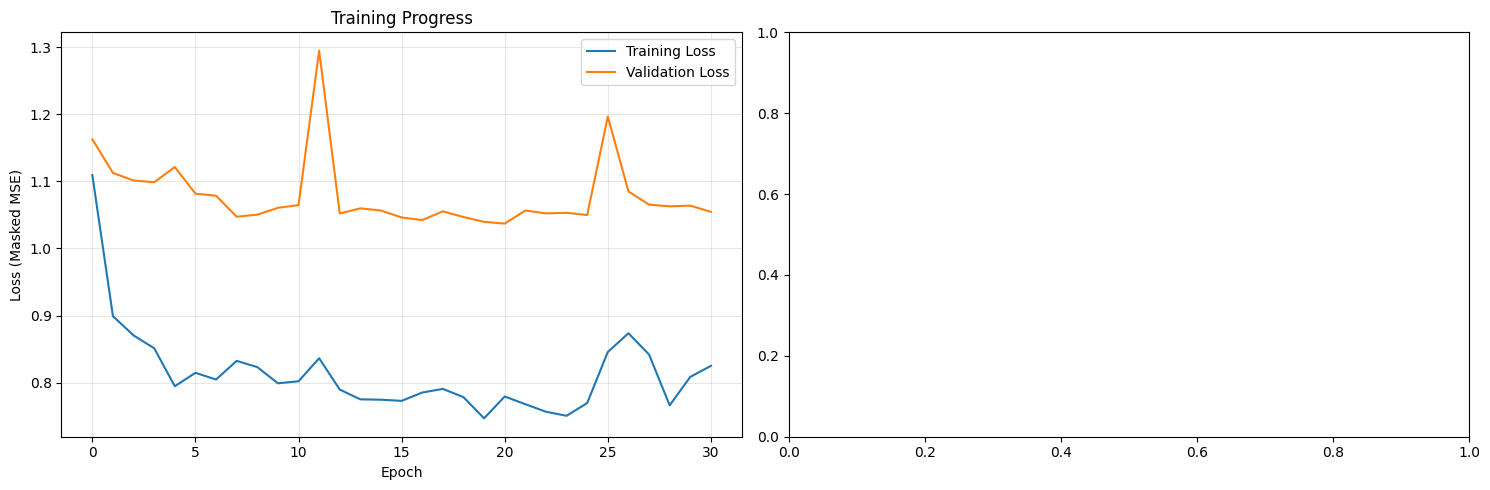

In [24]:
# =========================================
# 14. Visualisierung (optional)
# =========================================
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (Masked MSE)')
    axes[0].set_title('Training Progress')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Metric
    if 'masked_mae_metric' in history.history:
        axes[1].plot(history.history['masked_mae_metric'], label='Training MAE')
        axes[1].plot(history.history['val_masked_mae_metric'], label='Validation MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].set_title('Mean Absolute Error')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150)
    plt.show()

plot_training_history(history)



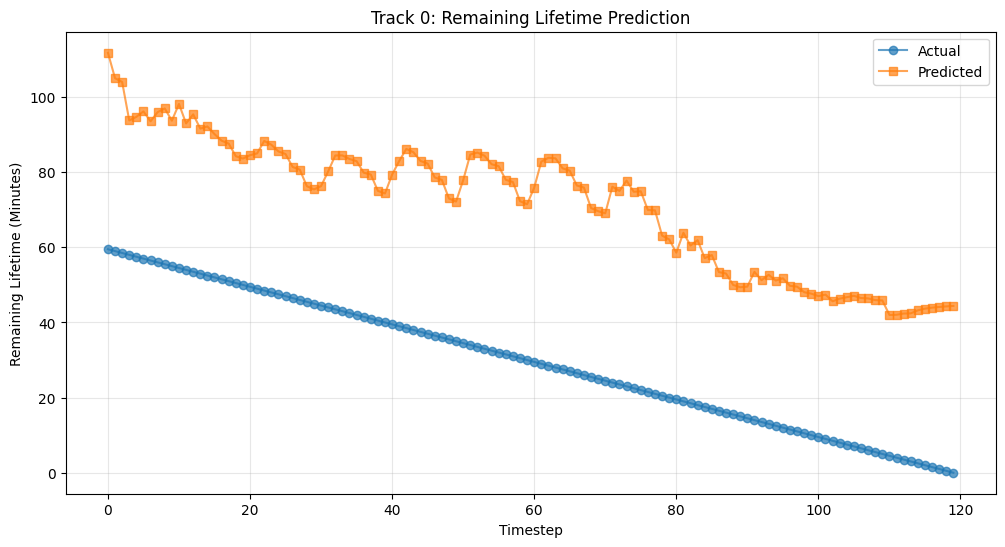


Track 0 Statistics:
MAE: 2503.61 seconds

✅ Training und Evaluation erfolgreich abgeschlossen!


In [25]:
# =========================================
# 15. Beispiel-Vorhersage für eine Wolke
# =========================================
def predict_single_track(model, track_idx=0):
    """Zeigt Vorhersage vs. Realität für einen Track"""
    
    # Hole einen Test-Track
    X_sample = X_test[track_idx:track_idx+1]
    y_true_sample = y_test_denorm[track_idx]
    y_pred_sample = y_pred[track_idx]
    
    # Finde echte Werte (nicht gepadete)
    mask = y_true_sample != PAD_VALUE
    mask = mask.flatten()
    
    timesteps = np.arange(len(mask))[mask]
    y_true_valid = y_true_sample[mask].flatten()
    y_pred_valid = y_pred_sample[mask].flatten()
    
    plt.figure(figsize=(12, 6))
    plt.plot(timesteps, y_true_valid / 60, 'o-', label='Actual', alpha=0.7)
    plt.plot(timesteps, y_pred_valid / 60, 's-', label='Predicted', alpha=0.7)
    plt.xlabel('Timestep')
    plt.ylabel('Remaining Lifetime (Minutes)')
    plt.title(f'Track {track_idx}: Remaining Lifetime Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'prediction_track_{track_idx}.png', dpi=150)
    plt.show()
    
    print(f"\nTrack {track_idx} Statistics:")
    print(f"MAE: {np.mean(np.abs(y_true_valid - y_pred_valid)):.2f} seconds")

predict_single_track(model, track_idx=0)

print("\n✅ Training und Evaluation erfolgreich abgeschlossen!")

In [21]:
!git clone https://github.com/thorsten789/hurricane_cloud_prediction.git

%cd /content/hurricane_cloud_prediction
!git pull

fatal: destination path 'hurricane_cloud_prediction' already exists and is not an empty directory.
/content/hurricane_cloud_prediction
Already up to date.


In [23]:
from scr_model.Protokollierung import save_json_with_timestamp
from scr_model.losses import cubic_mse, cubic_mse_masked

experiment_data = {
    "model": "RNN Baseline",
    "parameters": {
        "padding_type": "post",
        "padding_length": "max len"
    },
    "hyperparameters": {
        "optimizer": "adam",
        "units1": 64,
        "units2":32
    },
    "training": {
        "epochs": len(history.history["loss"]),
        "batch_size": BATCH_SIZE,
        "early_stopping": True
    },
    "results": {
        #"best_val_loss": float(val_loss),
        "test_loss": float(test_loss)
    }
}

save_json_with_timestamp("simple_rnn_experiment", experiment_data)

TypeError: float() argument must be a string or a real number, not 'list'